In [1]:
import pandas as pd
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools
import numpy as np
import pandas as pd
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from ipywidgets import interact
from tqdm.notebook import tqdm

Read the activity data from the CSV file

In [2]:
data_df = pd.read_csv("../data/activity_data.csv")

Look for the duplicated records in the dataframe

In [3]:
for k,v in data_df.groupby("SMILES"):
    if len(v) > 1:
        print(k,v['IC50 (uM)'].values)

CC(=O)N1CCN(CC(=O)Nc2cccc(S(N)(=O)=O)c2)CC1 [nan nan]
CC(C(=O)O)c1ccc2c(c1)[nH]c1ccc(Cl)cc12 [nan nan nan nan]
CC(C)N(C)C(=O)C1CCN(C(=O)CCl)CC1 [nan nan]
CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1 [nan nan nan]
COc1ccc2[nH]cc(CCNC(C)=O)c2c1 [nan nan]
CS(=O)(=O)Nc1cccc(C(=O)Nc2cccc(N3CCCC3=O)c2)c1 [nan nan]
Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1 [nan nan]
Cc1ccncc1NC(=O)Nc1cccc(Cl)c1 [68. 68.]
Cc1ccncc1NC(=O)Nc1ccccc1 [nan nan]
Cc1ccncc1NC(=O)c1cccc(NC(=O)Nc2cccnc2)c1 [nan nan]
N#Cc1ccc(NC(=O)Nc2cccnc2)cc1 [nan nan]
N#Cc1cccc(NC(=O)Nc2cccnc2)c1 [nan nan nan nan]
O=C(CCl)N1CCC(C(=O)N2CCCCC2)CC1 [nan nan]
O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1 [nan nan nan]
O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1 [nan nan]
O=C(CCl)N1CCN(Cc2cccs2)CC1 [5.66 5.66]
O=C(CCl)N1CCN(Cc2ccsc2)CC1 [3.27 3.27 3.27]
O=C(CCl)N1CCN(S(=O)(=O)c2c(F)cccc2F)CC1 [3.43 3.43]
O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1 [4.1 4.1]
O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1 [2.07 2.07]
O=C(CCl)Nc1cccc(N2CCCC2=O)c1 [72. 72. 72.]
O=C(c1cc(=O)[nH]c2ccccc12)N1

Remove the duplicated rows in the dataframe

In [4]:
before_rows = data_df.shape[0]
data_df.drop_duplicates("SMILES",inplace=True)
after_rows = data_df.shape[0]
print(f"{before_rows} rows reduced to {after_rows} rows")

310 rows reduced to 280 rows


Add a RDKit molecule column to the dataframe

In [5]:
data_df['mol'] = [Chem.MolFromSmiles(x) for x in data_df.SMILES]

Change the missing IC50 values to 999 and add a pIC50 column

In [6]:
data_df.fillna({'IC50 (uM)': 999},inplace=True)
data_df['pIC50'] = -np.log10([x * 1e-6 for x in data_df['IC50 (uM)'].values])

Add a compound to identify the covalent compounds 

In [7]:
chloromethylketone = Chem.MolFromSmarts('C(=O)[CH2]Cl')
acrylamide = Chem.MolFromSmarts('C(=O)[CH]=[CH2]')
data_df['covalent'] = [x.HasSubstructMatch(acrylamide) or x.HasSubstructMatch(chloromethylketone) for x in data_df.mol]

Add a fingerprint column

In [8]:
data_df['fp'] = [Chem.RDKFingerprint(x) for x in data_df.mol]

### Select covalent or noncovalent compounds.  
To select all compounds just set "df = data_df"

In [10]:
df = data_df.query("covalent == False")
df.shape
df.head(10)

,SMILES,CID,IC50 (uM),IC50 (uM) - std,Average Inhibition @ 20 uM,Average Inhibition @ 20 uM - std,Average Inhibition @ 50 uM,Average Inhibition @ 50 uM - std,Trypsin IC50 (uM),Relative Solubility @ 20 uM,Relative Solubility @ 100 uM,mol,pIC50,covalent,fp
0,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1,EDJ-MED-78f964c8-1,999.0,NaN,NaN,NaN,NaN,81.80,1.660,NaN,NaN,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, ..."
1,CS(=O)(=O)Nc1cccc(C(=O)Nc2cccc(N3CCCC3=O)c2)c1,MAK-UNK-1e8f9e3c-1,999.0,NaN,NaN,0.866,2.740,5.19,0.742,1.00,0.99,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, ..."
2,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,JAG-UCB-cedd89ab-8,68.0,7.1,> 99.0,32.100,0.539,58.70,0.386,0.99,0.96,"<img data-content=""rdkit/molecule"" src=""data:i...",4.167491,False,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
5,N#CCN1CCN(Cc2cc(Cl)cc3ccccc23)CC1,MAT-POS-4e253971-1,999.0,NaN,NaN,NaN,NaN,-1.08,0.303,NaN,NaN,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
7,COc1ccc2nc(C)cc(C(=O)NN)c2c1,MAT-POS-4e253971-3,999.0,NaN,NaN,NaN,NaN,17.90,1.080,NaN,NaN,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, ..."
32,CC(C(=O)O)c1ccc2c(c1)[nH]c1ccc(Cl)cc12,AAR-POS-fca48359-19,999.0,NaN,NaN,-0.548,0.936,3.97,0.598,1.00,0.98,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
34,NS(=O)(=O)c1ccc(N2CCSCC2)cc1,WAR-XCH-b72a1bbc-1,999.0,NaN,NaN,NaN,NaN,12.80,0.959,NaN,NaN,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
35,Cc1ccncc1-c1ccc(S(N)(=O)=O)cc1,WAR-XCH-b72a1bbc-4,999.0,NaN,NaN,NaN,NaN,3.16,1.640,NaN,NaN,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, ..."
36,NS(=O)(=O)c1ccc(N2CCC(c3ccco3)CC2)cc1,WAR-XCH-b72a1bbc-7,999.0,NaN,NaN,5.400,0.328,8.47,1.730,1.00,0.83,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
37,COC1CCN(c2ccc(S(N)(=O)=O)cc2)CC1,WAR-XCH-b72a1bbc-9,999.0,NaN,NaN,2.980,0.417,6.82,2.320,1.00,1.00,"<img data-content=""rdkit/molecule"" src=""data:i...",3.000435,False,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."


Calculate the [Structure Activity Landscape Index (SALI)](https://pubs.acs.org/doi/abs/10.1021/ci7004093) as $\dfrac{\Delta pIC_{50}}{1-Tanimoto}$.  Note that we add 0.001 to the denominator to avoid divide by zero errors.

In [11]:
pIC50_list = df.pIC50.values
smiles_list = df.SMILES.values
fp_list = df.fp.values
sal_list = []
for i,fp in enumerate(df.fp):
    sim_list = DataStructs.BulkTanimotoSimilarity(fp,fp_list)
    for j in range(0,i):
        ii,jj = i,j
        if pIC50_list[i] >= pIC50_list[j]:
            ii,jj = i,j
        else:
            jj,ii = i,j
        delta = abs(pIC50_list[i]-pIC50_list[j])
        sim = sim_list[j]
        sal_list.append([ii,jj,sim,delta/(1-sim+0.001),smiles_list[ii],smiles_list[jj],pIC50_list[ii],pIC50_list[jj]])

Create a dataframe with the SALI data

In [12]:
sal_df = pd.DataFrame(sal_list,columns=["i","j","Sim","SAL","SMILES_i","SMILES_j","pIC50_i","pIC50_j"])
sal_df.sort_values("SAL",ascending=False,inplace=True)
sal_df = sal_df.head(100)

Add molecule columns to the SALI dataframe

In [13]:
PandasTools.AddMoleculeColumnToFrame(sal_df,"SMILES_i","Mol_i")
PandasTools.AddMoleculeColumnToFrame(sal_df,"SMILES_j","Mol_j")

,i,j,Sim,SAL,SMILES_i,SMILES_j,pIC50_i,pIC50_j,Mol_i,Mol_j
860,41,40,0.866242,11.834045,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,Cc1ccncc1NC(=O)Cc1ccccc1,4.595166,3.000435,,
943,43,40,0.860759,8.524114,Cc1ccncc1NC(=O)Cc1cccc(C#N)c1,Cc1ccncc1NC(=O)Cc1ccccc1,4.195861,3.000435,,
14408,43,170,0.845992,7.712006,Cc1ccncc1NC(=O)Cc1cccc(C#N)c1,N#Cc1cccc(CC(=O)Nc2cccnc2)c1,4.195861,3.000435,,
743,2,39,0.843521,7.410861,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,Cc1ccncc1NC(=O)Nc1ccccc1,4.167491,3.000435,,
11628,153,0,0.667406,6.454633,COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2ccccc12,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1,5.153663,3.000435,,

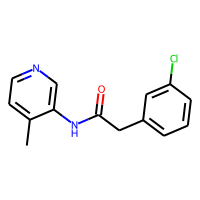
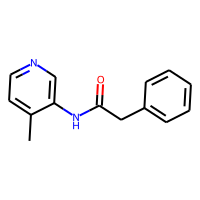
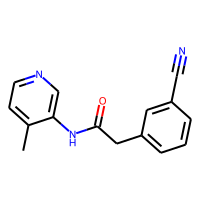
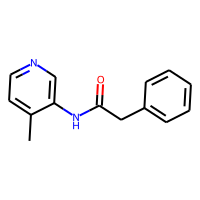
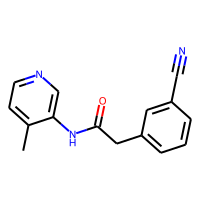
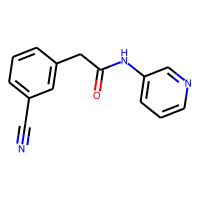
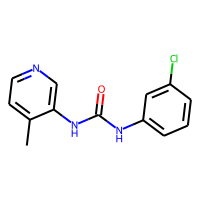
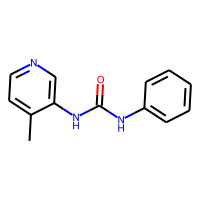
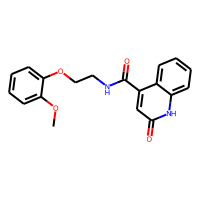
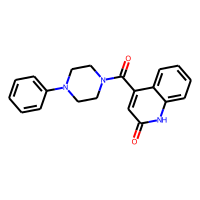

In [14]:
sal_df.head()

Align pairs of molecules based on the Maximum Common Subgraph (MCS)

In [15]:
def align_mols(df_in):
    mcs_list = []
    for idx, [mol_i,mol_j] in tqdm(df_in[["Mol_i","Mol_j"]].iterrows(),total=df_in.shape[0]):
        mcs = rdFMCS.FindMCS([mol_i, mol_j],completeRingsOnly=True)
        mcs_query = Chem.MolFromSmarts(mcs.smartsString)
        AllChem.Compute2DCoords(mcs_query)
        AllChem.GenerateDepictionMatching2DStructure(mol_i,mcs_query)
        AllChem.GenerateDepictionMatching2DStructure(mol_j,mcs_query)
        
align_mols(sal_df)

  0%|          | 0/100 [00:00<?, ?it/s]

View the pairs of molecules. The more active molecule is always on the left. 

In [16]:
#@interact(row_num=range(0,100)) #control with a menu
@interact(row_num=(0,99,1)) #control with a slider
def show_pair(row_num=0):
    row = sal_df.iloc[row_num]
    mol_i = row.Mol_i
    mol_j = row.Mol_j
    i = row.i
    j = row.j
    legends = [f"{df.iloc[i].CID} | {df.iloc[i]['IC50 (uM)']:.2f}",f"{df.iloc[j].CID} | {df.iloc[j]['IC50 (uM)']:.2f}"]
    print(df.iloc[i].CID,i)
    print(df.iloc[j].CID,j)
    print(f"SAL = {row.SAL:.2f}")
    print(f"Tanimoto = {row.Sim:.2f}")
    delta = 10**(abs(row.pIC50_i-row.pIC50_j))
    print(f"Delta = {delta:.1f}")
    return MolsToGridImage([mol_i,mol_j],molsPerRow=2,subImgSize=(300, 300),legends=legends)

interactive(children=(IntSlider(value=0, description='row_num', max=99), Output()), _dom_classes=('widget-inte…